In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.axes import Axes
import pandas as pd

from stoneforge.preprocessing import las_import

In [3]:
data,units = las_import("..//stoneforge//datasets/DP1.las")
data

,DEPT,SP,ILD,ILM,LL8,GR,CALI,DRHO,RHOB,NPHI,DT
0,100.0,-999.0,-999.0,-999.0,-999.0,25.1383,-999.0,-999.0,-999.0,-999.0,-999.0
1,100.5,-999.0,-999.0,-999.0,-999.0,24.7342,-999.0,-999.0,-999.0,-999.0,-999.0
2,101.0,-999.0,-999.0,-999.0,-999.0,24.9611,-999.0,-999.0,-999.0,-999.0,-999.0
3,101.5,-999.0,-999.0,-999.0,-999.0,25.1880,-999.0,-999.0,-999.0,-999.0,-999.0
4,102.0,-999.0,-999.0,-999.0,-999.0,25.4148,-999.0,-999.0,-999.0,-999.0,-999.0
...,...,...,...,...,...,...,...,...,...,...,...
15688,7944.0,-999.0,-999.0,-999.0,-999.0,-999.0000,-999.0,-999.0,-999.0,-999.0,-999.0
15689,7944.5,-999.0,-999.0,-999.0,-999.0,-999.0000,-999.0,-999.0,-999.0,-999.0,-999.0
15690,7945.0,-999.0,-999.0,-999.0,-999.0,-999.0000,-999.0,-999.0,-999.0,-999.0,-999.0
15691,7945.5,-999.0,-999.0,-999.0,-999.0,-999.0000,-999.0,-999.0,-999.0,-999.0,-999.0


In [4]:
print(units)

{'DEPT': 'F', 'SP': 'MV', 'ILD': 'OHMM', 'ILM': 'OHMM', 'LL8': 'OHMM', 'GR': 'GAPI', 'CALI': 'IN', 'DRHO': 'G/C3', 'RHOB': 'G/C3', 'NPHI': '%', 'DT': 'US/F'}


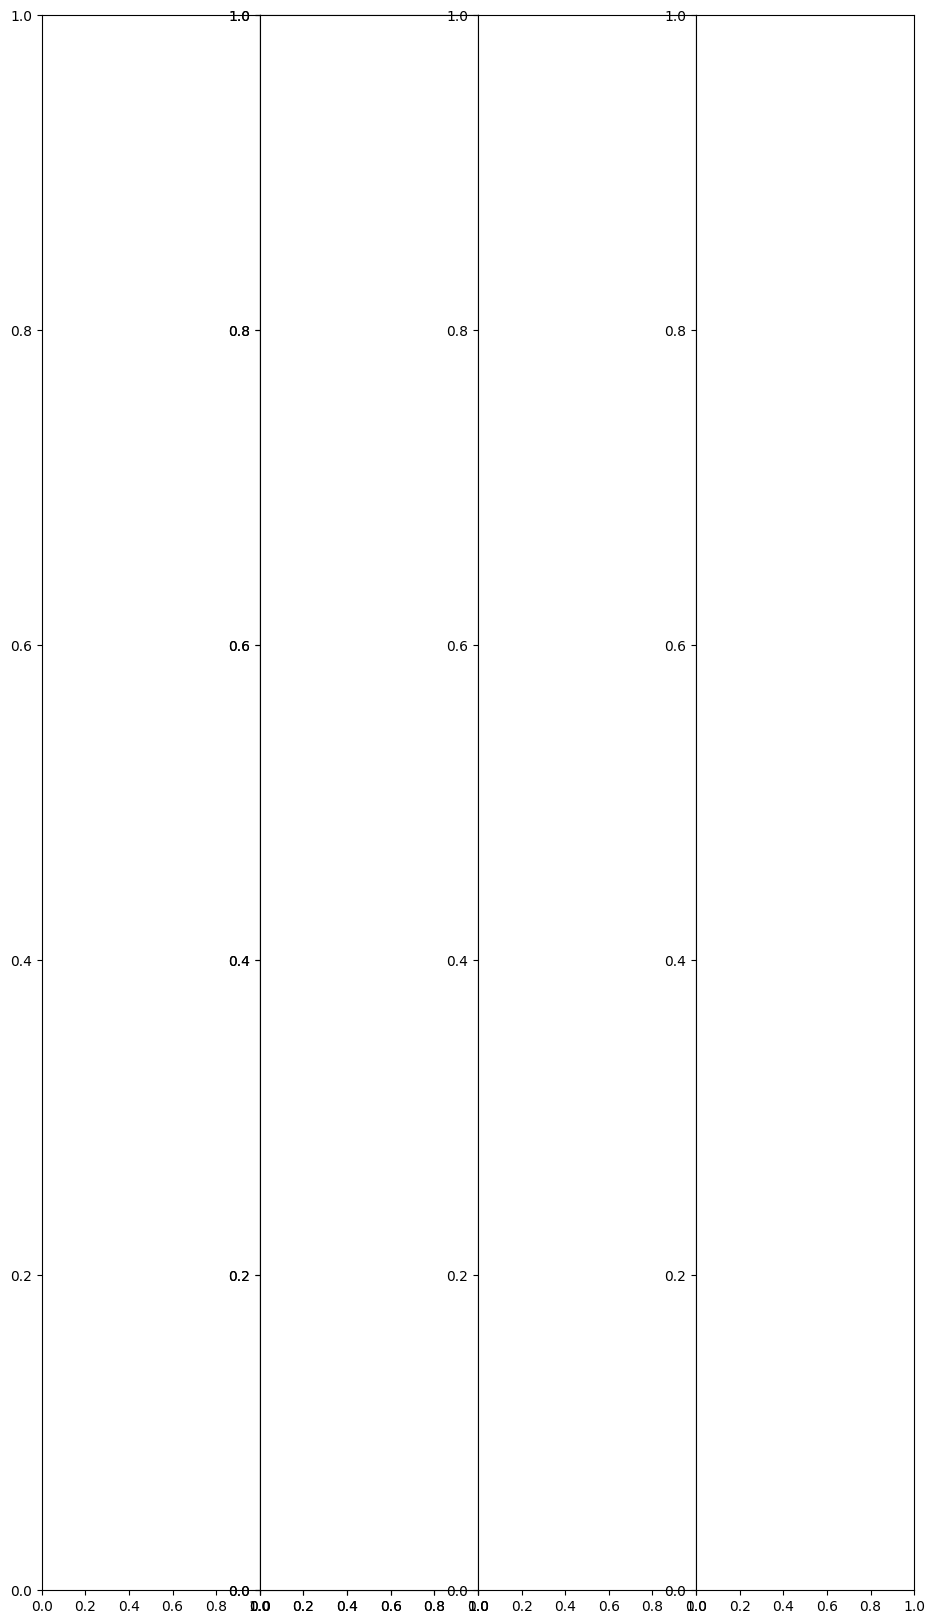

In [5]:
CM = 0.3937  # centimeters in inches
fig = plt.figure(figsize=(27.7*CM, 40*CM))

ax1 = fig.add_axes([0.1, 0.1, 0.2, 1.0])
ax2 = fig.add_axes([0.3, 0.1, 0.2, 1.0])
ax3 = fig.add_axes([0.3, 0.1, 0.2, 1.0])
ax4 = fig.add_axes([0.5, 0.1, 0.2, 1.0])
ax5 = fig.add_axes([0.7, 0.1, 0.2, 1.0])

plt.show()

In [179]:
class LogPlot:

    def __init__(self, size=(27.7, 40.0), top=None, bot=None, title=('Well',2),):
        self.cm = 0.3937
        self.fig = plt.figure(figsize=(size[0]*self.cm, size[1]*self.cm))
        
        self.ax = None
        self.xzeros = []
        self.yzeros = []
        self.widths = []
        self.heights = []
        self._first_track = True
        self.title = title

        self._subs = 0
        self._bar = (int(0.9167 * size[0] + 0.833))*'─'

        self.y = None
        self.depth_description = "Depth"
        self.top = top
        self.bot = bot

    """
    def _format_bar(self, min_val, max_val, label):
        bar_str = self._bar
        total_length = len(bar_str)
        
        min_str = str(min_val)
        max_str = str(max_val)
        label_str = f" {label} "
        
        fixed_space = len(min_str) + len(max_str) + len(label_str) + 2
        remaining_space = total_length - fixed_space
        
        if remaining_space < 0:
            raise ValueError("Bar is too short to fit min, max, and label")
        
        left_dashes = remaining_space // 2
        right_dashes = remaining_space - left_dashes
        
        new_bar = (
            f"{min_str} " +
            "─" * left_dashes +
            label_str +
            "─" * right_dashes +
            f" {max_str}"
        )
        
        return new_bar
    """
    def _format_bar(self, min_val, max_val, label):
        bar_str = self._bar
        total_length = len(bar_str)
        min_str = str(min_val)
        max_str = str(max_val)
        
        fixed_space = len(min_str) + len(max_str) + 2
        
        remaining_space = total_length - fixed_space
        
        if remaining_space < 0:
            raise ValueError("Bar is too short to fit min and max values")
        
        bar_line = f"{min_str} " + "─" * remaining_space + f" {max_str}"
        visual_length = len(bar_line)
        centered_label = label.center(visual_length)
        formatted_bar = f"{centered_label}\n{bar_line}"
        
        return formatted_bar

    def _addtrack(self, w=0.2, pos=False):
        if self.xzeros:
            if pos:
                self.xzeros.append(self.xzeros[-1])
                self._subs += 1
            else:
                self.xzeros.append(self.xzeros[-1] + self.widths[-1])
                self._subs = 0
        else:
            self.xzeros.append(0.1)

        self.yzeros.append(0.1)
        self.widths.append(w)
        self.heights.append(1.0)
        
        self.ax = self.fig.add_axes([self.xzeros[-1], self.yzeros[-1], self.widths[-1], self.heights[-1]])
        self.ax.patch.set_alpha(0)
        self.ax.set_xticklabels([])
        
        if not self._first_track:
            self.ax.set_yticklabels([])
        else:
            self.ax.set_ylabel(self.depth_description)
        
        self._first_track = False

    def set_depth(self, y, d, res = (1,1000), dpi = 300):
        self.y = y
        self.depth_description = d
        
        if self.top == None:
            self.top = np.nanmin(y)
            
        if self.top == None:
            self.bot = np.nanmax(y)

        _range = self.bot - self.top
        print(_range,'m')
        self.depth_range = np.arange(self.top,self.bot,50) 

    def nplot(self, x, c='black', s='-', w=0.2, pos=False, vmin=None, vmax=None, step=10, label='', grid = False):
        self._addtrack(w=w, pos=pos)
        if not pos and grid == False:
            self.ax.minorticks_on()  # Turn on minor ticks
            self.ax.grid(which='major',axis = 'y', linewidth=1.8)  # Keep the main grid
            self.ax.grid(which='major',axis = 'x', linewidth=0.4)  # Keep the main grid
            self.ax.grid(which='minor',axis = 'y', linewidth=0.4)  # Add subgrid lines
        if vmin == None:
            vmin = np.nanmin(x)
        if vmax == None:
            vmax = np.nanmax(x)
        _title = self._format_bar(vmin, vmax, label)
        self.ax.set_xticks(np.linspace(vmin,vmax,step+1))
        self.ax.set_yticks(self.depth_range)
        self.ax.plot(x, self.y, color=c, linestyle=s, linewidth=0.5)
        self.ax.set_xlim(vmin,vmax)
        #self.ax.set_xticklabels([])
        self.ax.set_ylim(self.bot,self.top)
        self.ax.set_title(_title+'\n'*self._subs*2, color = c, fontsize=10)

    def lplot(self, x, c='black', s='-', w=0.2, pos=False, vmin=None, vmax=None, step=10, label='', grid = False):
        self._addtrack(w=w, pos=pos)
        if not pos and grid == False:
            #self.ax.grid()
            #self.ax.grid(which="minor", color="0.9")
            self.ax.minorticks_on()  # Turn on minor ticks
            self.ax.grid(which='major',axis = 'y', linewidth=1.8)  # Keep the main grid
            self.ax.grid(which='major',axis = 'x', linewidth=0.8)  # Keep the main grid
            self.ax.grid(which='minor',axis = 'y', linewidth=0.4)  # Add subgrid lines
            self.ax.grid(which='minor',axis = 'x', linewidth=0.4)  # Add subgrid lines
        if vmin == None:
            vmin = np.nanmin(x)
        if vmax == None:
            vmax = np.nanmax(x)
        _title = self._format_bar(vmin, vmax, label)
        self.ax.set_xticks(np.linspace(vmin,vmax,step+1))
        self.ax.set_yticks(self.depth_range)
        self.ax.semilogx(x, self.y, color=c, linestyle=s, linewidth=0.5)
        self.ax.set_xlim(vmin,vmax)     
        self.ax.set_xticklabels([])
        self.ax.set_ylim(self.bot,self.top)
        self.ax.set_title(_title+'\n'*self._subs*2, color = c, fontsize=10)

    def fplot(self, x, c='black', s='-', w=0.2, pos=False, vmin=None, vmax=None, step=10, label='', grid = False):
        self._addtrack(w=w, pos=pos)
        if not pos and grid == False:
            self.ax.minorticks_on()  # Turn on minor ticks
            self.ax.grid(which='major',axis = 'y', linewidth=1.8)  # Keep the main grid
            self.ax.grid(which='major',axis = 'x', linewidth=0.4)  # Keep the main grid
            self.ax.grid(which='minor',axis = 'y', linewidth=0.4)  # Add subgrid lines
        if vmin == None:
            vmin = np.nanmin(x)
        if vmax == None:
            vmax = np.nanmax(x)
        _title = self._format_bar(vmin, vmax, label)
        self.ax.set_xticks(np.linspace(vmin,vmax,step+1))
        self.ax.set_yticks(self.depth_range)
        self.ax.plot(x, self.y, color=c, linestyle=s, linewidth=0.5)
        self.ax.fill_betweenx(self.y, x, vmax, color=c)
        self.ax.set_xlim(vmin,vmax)
        #self.ax.set_xticklabels([])
        self.ax.set_ylim(self.bot,self.top)
        self.ax.set_title(_title+'\n'*self._subs*2, color = c, fontsize=10)

    def show(self):
        self.fig.suptitle(self.title[0], fontsize=40, x=0.65, y=self.title[1])
        self.fig.text(0.65, self.title[1]-0.007, f"DEPTH : {int(self.top)} / {int(self.bot)} M", ha='center', fontsize=18)
        self.fig.text(0.2, self.title[1]-0.007, "Scale : 1 : 1000", ha='center', fontsize=18)
        plt.show()

    def save(self):
        plt.savefig('image.png', bbox_inches='tight', dpi=300)

400 m


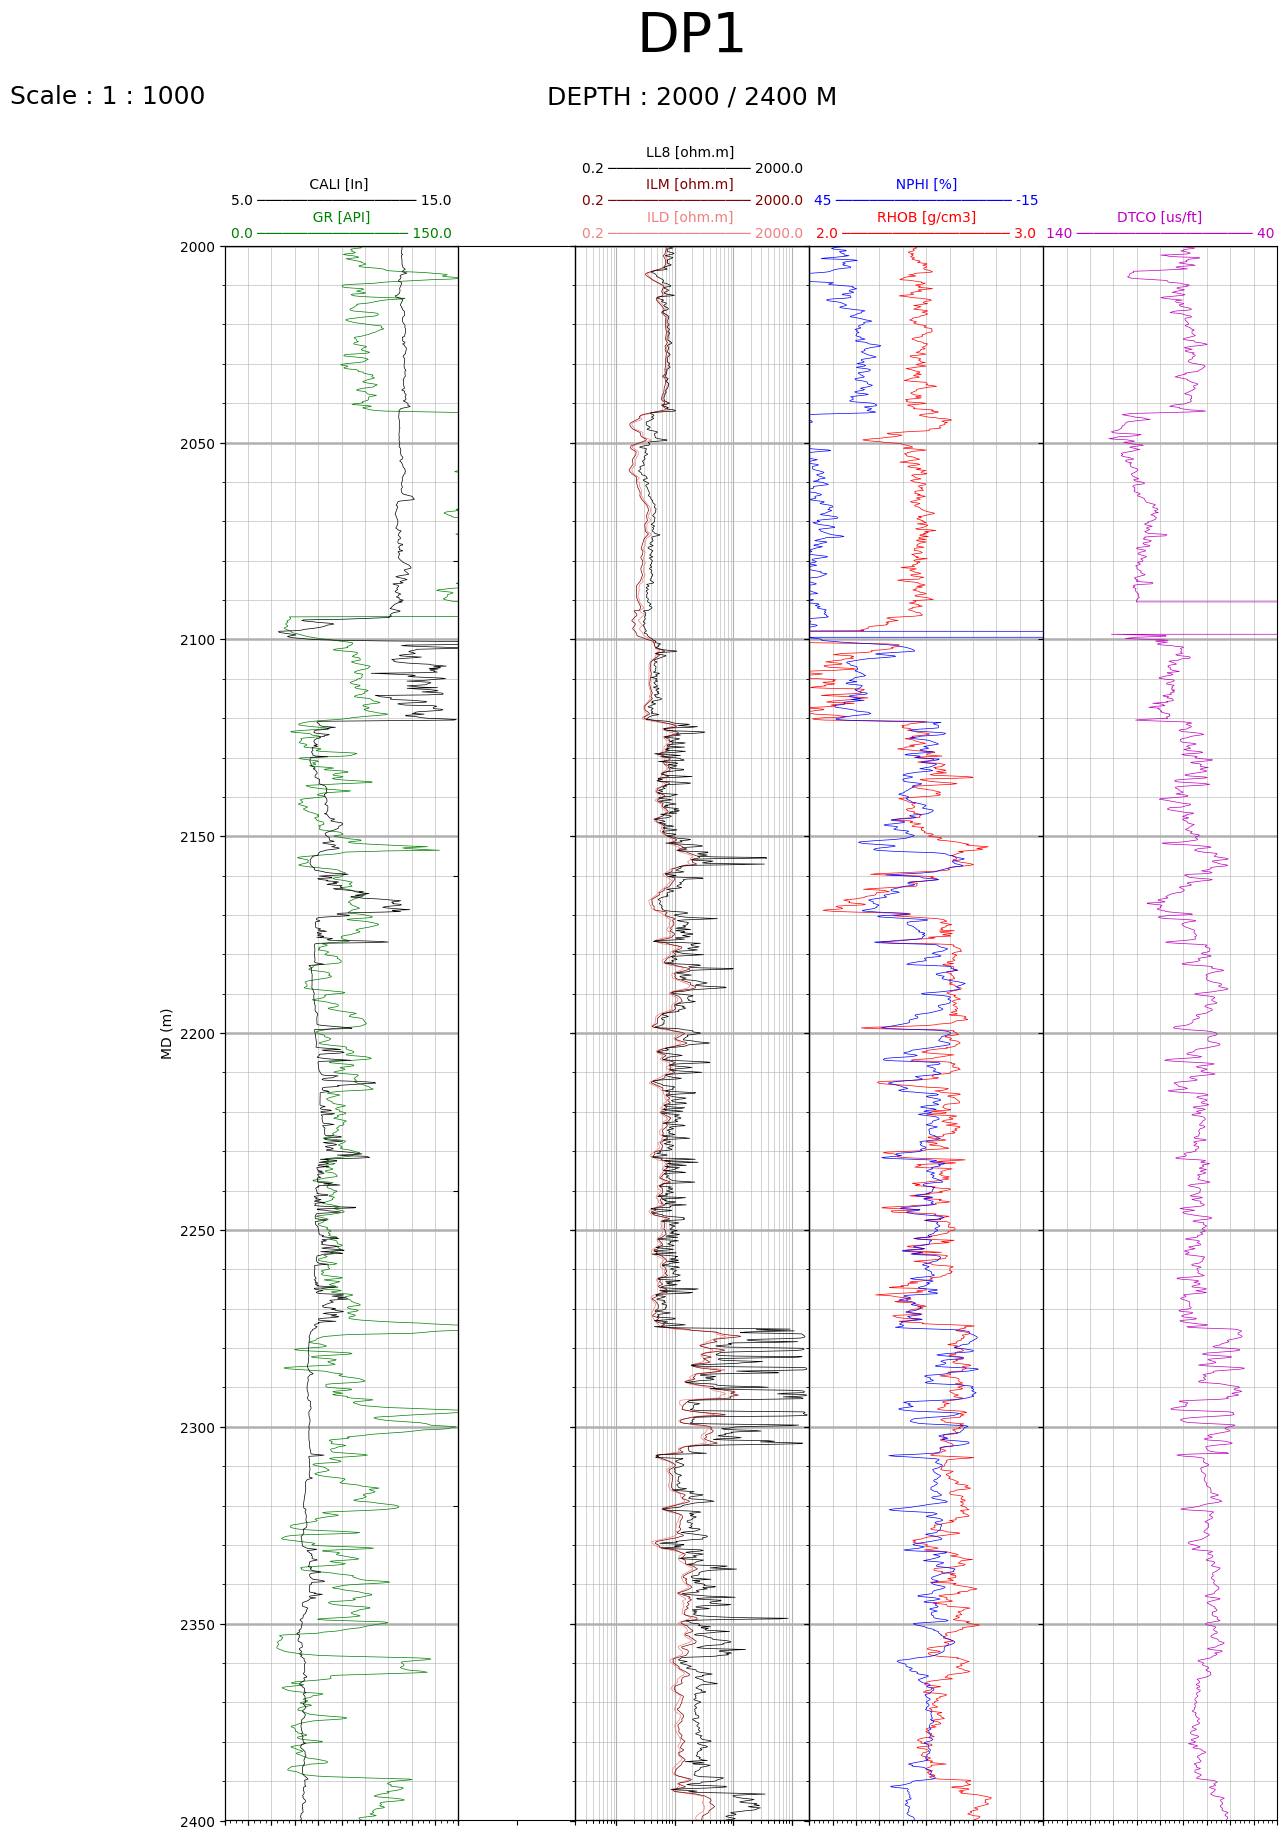

In [180]:
img = LogPlot(size=(29.7, 40),top=2000, bot=2400, title=("DP1",1.25))
img.set_depth(data['DEPT']*0.3048, d="MD (m)") # ,top=6000,bot=7000
img.nplot(x = data['GR'],c = 'g', vmin=0., vmax = 150., label = 'GR [API]')
img.nplot(x = data['CALI'],c = 'k', pos = True, vmin=5., vmax = 15., label = 'CALI [In]')
img._addtrack(w = 0.1)
img.lplot(x = data['ILD'],c = 'lightcoral', vmin=.2, vmax = 2000., label = 'ILD [ohm.m]')
img.lplot(x = data['ILM'],c = 'maroon', pos = True, vmin=.2, vmax = 2000., label = 'ILM [ohm.m]')
img.lplot(x = data['LL8'],c = 'k', pos = True, vmin=.2, vmax = 2000., label = 'LL8 [ohm.m]')

img.nplot(x = data['RHOB'],c = 'r', vmin=2., vmax = 3., label = 'RHOB [g/cm3]')
img.nplot(x = data['NPHI'],c = 'b', pos = True, vmin=45, vmax=-15, label = 'NPHI [%]')

img.nplot(x = data['DT'],c = 'm',vmin=140, vmax=40, label = 'DTCO [us/ft]')
a = img.show()
#img.save()